In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from helper_functions import *

# Benchmarking:

January 2, 1991 to April 30, 2018

- DJIA  
* First 4500 days is training
* Next 1300 days is validation
* The rest is testing

In [34]:
####### EXPERIMENT DEPENDENT
WINDOW_SIZE = 20  # SAME AS ZHANG ET AL.

####### DO NOT CHANGE BELOW
TRAIN_END = 4500
VAL_END = 4500 + 1300
SEQ_LEN = WINDOW_SIZE


## DJIA

In [35]:
PATH = "^IXIC1991_2018.csv"
df = pd.read_csv(PATH, index_col = 'Date', parse_dates=True)
df.head(5) ; print(len(df))

6884


### **Modify all input columns into residual**

**Use previous day columns (including closing price) to predict next day results**

In [36]:
print(len(df))
X = apply_residual_change(df); print(X.shape);
y = apply_residual_change(df['Close']); print(y.shape)

X, y = build_base_X_y_difference(X, y); print(X.shape, y.shape)

y = y.reshape(-1, 1)

assert X.shape[0] == len(df)-2, "ERROR: SOME OPERATION ERROR DURING DATA ENGINEERING"
assert X.shape[0] == y.shape[0], "ERROR : X AND y HAVE DIFFERENT LEN"

USABLE_DATA_LEN = X.shape[0]

6884
(6883, 6)
(6883,)
6882 6882
(6882, 6) (6882,)


Transform the data to between 0 - 1 so the network converges faster

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()     # minMax on the y for quicker learning. More suitable than SS

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(y) 

##### Train_val_test

In [38]:
X_train_tensors_final, X_val_tensors_final, X_test_tensors_final, \
    y_train_tensors, y_val_tensors, y_test_tensors = create_datatensors(X_mm, y_mm)

In [39]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 20, 6]) torch.Size([4500, 1])
Testing Shape torch.Size([1300, 20, 6]) torch.Size([1300, 1])
Testing Shape torch.Size([1062, 20, 6]) torch.Size([1062, 1])


In [40]:
a = len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)
b = len(y_test_tensors) + len(y_train_tensors) + len(y_val_tensors)
assert a == b, "X AND Y UNEQUAL LEN"

USABLE_DATA_LEN =  len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)

#### GridSearch

In [41]:
model_params = {
        'input_size': 6,
        'num_layers': 1,
        'num_classes': 1,
        'criterion': torch.nn.MSELoss(),
        'learning_rate': 0.001,
        'hidden_sizes': [5, 15, 30],
        'lookback': [1, 5, 10],
        'sequence_len': 20
    }

model = 'lstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

lstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 13 with validation loss: 0.0021773412420482536
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 16 with validation loss: 0.002180266540452111
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 17 with validation loss: 0.002177874316325093
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 13 with validation loss: 0.002180086302559641
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 12 with validation loss: 0.0022105662984114776
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 12 with validation loss: 0.0022100723751752476
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 32 with validation loss: 0.002215237725844107
#-------------------------
Now running model: Hidden-size 15,  l

##### Inverse compute Price Graph

How to compute?

Since we will **always** have access to the figures from yesterday, it means we will multiply the previous day 'Close' price with the predicted ratio.

In [42]:
# Create Dicts to store results
days_1 = dict()
days_3 = dict()
days_7 = dict()

In [43]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  lstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 2538.048141
MAE: 35.603067
RMSE: 50.379045
MAPE: 18.070072

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 2536.715789
MAE: 35.620489
RMSE: 50.365820
MAPE: 0.678493


In [44]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 797.302163
MAE: 20.495981
RMSE: 28.236540
MAPE: 0.391843


In [45]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 304.103242
MAE: 12.892552
RMSE: 17.438556
MAPE: 0.244412


##### plots

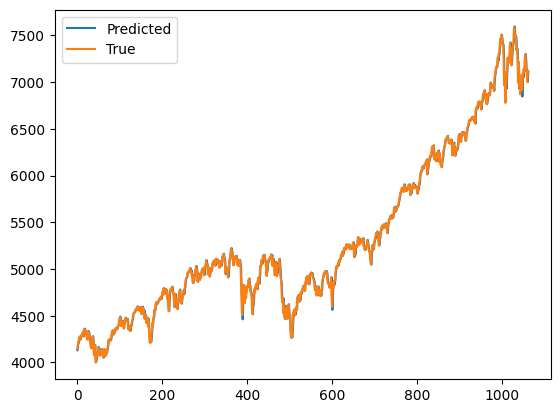

In [46]:
plt.plot(result, label = 'Predicted')
plt.plot(y_groundtruth, label = 'True')
plt.legend()
plt.show()

## RNN

##### RNN

In [47]:
# use the same parameters as above
#
model = 'rnn'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

rnn_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 23 with validation loss: 0.002240931635109208
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0022591504214399655
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0022825688399124616
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 13 with validation loss: 0.002326535900043914
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 13 with validation loss: 0.0023304192298205526
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 17 with validation loss: 0.002338977760589886
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 12 with validation loss: 0.0023454921305883767
#-------------------------
Now running model: Hidden-size 15,  

In [48]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  rnn

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 2823.256396
MAE: 38.653617
RMSE: 53.134324
MAPE: 18.054337

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 2536.715789
MAE: 35.620489
RMSE: 50.365820
MAPE: 0.678493


In [49]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 932.811240
MAE: 23.617536
RMSE: 30.541959
MAPE: 0.451389


In [50]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 449.008121
MAE: 16.651774
RMSE: 21.189812
MAPE: 0.315611


## GRU

In [51]:
# use the same parameters as above
#
model = 'gru'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

gru_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 21 with validation loss: 0.002190230973632779
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 11 with validation loss: 0.002226286607499166
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0022601577035923737
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 13 with validation loss: 0.002328876468421119
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 11 with validation loss: 0.002339693788643472
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 18 with validation loss: 0.0023488258863458545
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 16 with validation loss: 0.0023784427207940054
#-------------------------
Now running model: Hidden-size 15,  l

In [52]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  gru

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 2833.161433
MAE: 38.014819
RMSE: 53.227450
MAPE: 18.072461

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 2536.715789
MAE: 35.620489
RMSE: 50.365820
MAPE: 0.678493


In [53]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 911.320456
MAE: 22.371204
RMSE: 30.188085
MAPE: 0.427634


In [54]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 429.168749
MAE: 15.157051
RMSE: 20.716388
MAPE: 0.286600


## Bi-LSTM

In [55]:
# use the same parameters 
#
model = 'blstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

blstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1
Early stopping at epoch 43 with validation loss: 0.002189041001767647
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 14 with validation loss: 0.0021847052238427285
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 21 with validation loss: 0.0021878639079925674
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 17 with validation loss: 0.0021897308548299095
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 18 with validation loss: 0.002190792578181661
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 16 with validation loss: 0.0021905106614434683
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 17 with validation loss: 0.002191669

In [56]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  blstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 2557.491223
MAE: 36.329879
RMSE: 50.571644
MAPE: 18.055196

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 2536.715789
MAE: 35.620489
RMSE: 50.365820
MAPE: 0.678493


In [57]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 852.753524
MAE: 22.263734
RMSE: 29.201944
MAPE: 0.425347


In [58]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 395.673764
MAE: 15.474725
RMSE: 19.891550
MAPE: 0.293203


## Stacked LSTM

In [59]:
#
model = 'stackedlstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

stackedlstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 19 with validation loss: 0.0021767954515270523
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 12 with validation loss: 0.0021811704528972324
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 16 with validation loss: 0.002189375417556886
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 27 with validation loss: 0.002196950349593308
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 27 with validation loss: 0.002197714193110786
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 14 with validation loss: 0.002201005851952132
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 12 with validation loss: 0.0022045704848473757
#-------------------------
Now running model: Hidden-size 15,  l

In [60]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  stackedlstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 2547.868632
MAE: 35.794802
RMSE: 50.476417
MAPE: 18.062899

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 2536.715789
MAE: 35.620489
RMSE: 50.365820
MAPE: 0.678493


In [61]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 826.873653
MAE: 21.254411
RMSE: 28.755411
MAPE: 0.405600


In [62]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 347.948347
MAE: 14.010153
RMSE: 18.653374
MAPE: 0.265396


# Data aggregation

In [63]:
# DICTS
# days_1 = dict()
# days_3 = dict()
# days_7 = dict()

In [64]:
days1df = pd.DataFrame(days_1, index=['mse', 'mae', 'rmse', 'mape'])
days3df = pd.DataFrame(days_3, index=['mse', 'mae', 'rmse', 'mape'])
days7df = pd.DataFrame(days_7, index=['mse', 'mae', 'rmse', 'mape'])

In [65]:
def highlight_min_and_second_min(s):
    sorted_vals = sorted(s)
    min_val = sorted_vals[0]  # Get the lowest value in each row
    second_min_val = sorted_vals[1]  # Get the second lowest value in each row
    is_min = s == min_val
    is_second_min = s == second_min_val
    styles = ['font-weight: bold' if v else '' for v in is_min]
    for i, v in enumerate(is_second_min):
        if v:
            styles[i] += 'text-decoration: underline'
    return styles

styled_df = days1df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,2538.048141,2823.256396,2833.161433,2557.491223,2547.868632
mae,35.603067,38.653617,38.014819,36.329879,35.794802
rmse,50.379045,53.134324,53.227450,50.571644,50.476417
mape,18.070072,18.054337,18.072461,18.055196,18.062899


In [66]:
styled_df = days3df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,797.302163,932.811240,911.320456,852.753524,826.873653
mae,20.495981,23.617536,22.371204,22.263734,21.254411
rmse,28.236540,30.541959,30.188085,29.201944,28.755411
mape,0.391843,0.451389,0.427634,0.425347,0.405600


In [67]:
styled_df = days7df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,304.103242,449.008121,429.168749,395.673764,347.948347
mae,12.892552,16.651774,15.157051,15.474725,14.010153
rmse,17.438556,21.189812,20.716388,19.891550,18.653374
mape,0.244412,0.315611,0.286600,0.293203,0.265396
